In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.patches as mpatches
from physoce import tseries as ts
from scipy.signal import welch
from scipy.stats import chi2
from scipy import stats

In [3]:
#load combined file from ADV processing code
os.chdir("c:/Users/steve/Desktop/STILL1/ADV_8102017/")
filename ="combined.csv"
df = pd.read_csv(filename)

In [4]:
start_time1, end_time1 = (1108, 1128) #select start and end time of in kelp run 
start_time2, end_time2 = (1145, 1205)#select start and end time of out of bed run 
df['Time']= (df['Hour']*100)+ (df['Minute']) #make new time column for indexing in military time
runindex_in = (df['Time']>start_time1-1) & (df['Time']<end_time1+1) # index by start and end time for in bed run
runindex_out = (df['Time']>start_time2-1) & (df['Time']<end_time2+1) # index by start and end time for out of bed run

In [5]:
#use PCA to rotate axis to make variable with most variation U
theta, major, minor=ts.princax(df['Velocity_East(m/s)'], df['Velocity_North(m/s)']) #theta = angle, major = SD major axis, SD minor axis 
U, V= ts.rot(df['Velocity_East(m/s)'], df['Velocity_North(m/s)'], -theta)

In [6]:
df['U'] = U
df['V']= V

In [11]:
#make variables you want to play with 
U_in = df['U'][runindex_in]
U_out = df['U'][runindex_out]
N1 = (len(U_in))
N2 = (len(U_out))

In [12]:
print(U)

[ 2.16068513 -2.14880002  0.89353069 ...,  0.27930742         nan
         nan]


<IPython.core.display.Javascript object>


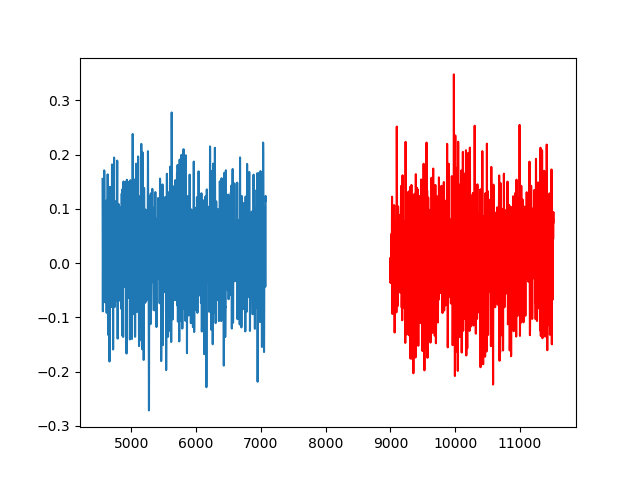

In [13]:
plt.figure()
plt.plot(U_in)
plt.plot(U_out, 'r')

plt.show()

In [14]:
U_fft_in = np.fft.fft(U_in) #Fast Fourier Transform alogorithm
U_fft_out = np.fft.fft(U_out)

<IPython.core.display.Javascript object>


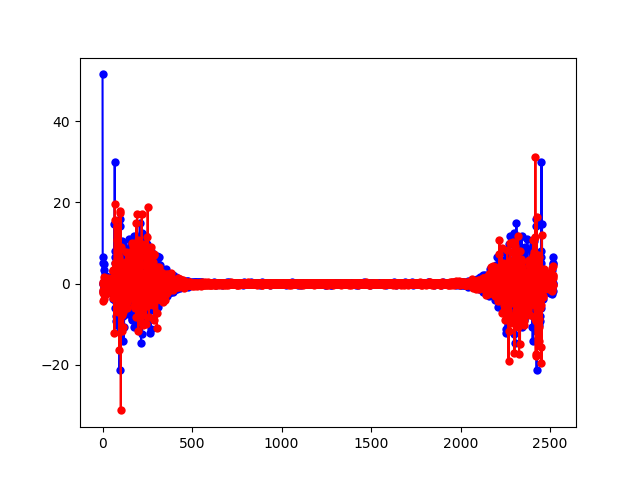

In [15]:
plt.figure()
plt.plot(np.real(U_fft_in),'b-o',markeredgecolor='none')
plt.plot(np.imag(U_fft_in),'r-o',markeredgecolor='none')
plt.show()

In [16]:
deltat1 = .5
deltat2 = .5
f_in = np.fft.fftfreq(N1,deltat1)
S_in = (2/N1)*deltat1*np.abs(U_fft_in)**2

f_out = np.fft.fftfreq(N2, deltat2)
S_out = (2/N2)*deltat2*np.abs(U_fft_out)**2

<IPython.core.display.Javascript object>


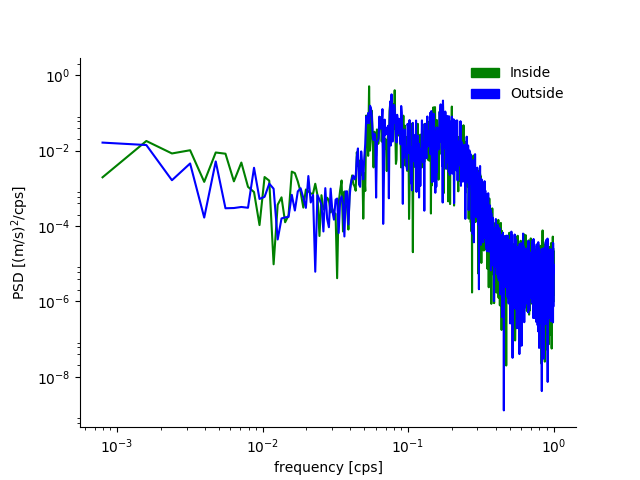

In [17]:
fig, ax = plt.subplots()

plt.loglog(f_in[0:round(N1/2)],S_in[0:round(N1/2)], 'g')
plt.loglog(f_out[0:round(N2/2)],S_out[0:round(N2/2)], 'b')
plt.xlabel('frequency [cps]')
plt.ylabel('PSD [(m/s)$^2$/cps]') #power spectral density 
green_patch = mpatches.Patch(color='green', label='Inside')
blue_patch = mpatches.Patch(color='blue', label='Outside')
plt.legend(loc = 1,bbox_to_anchor=(1, 1.01), handles=[green_patch, blue_patch], frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.savefig('run1_90stipesN.jpg', dpi=1000)
plt.show()

In [58]:
f2_in,S2_in = welch(U_in,fs=.5,nperseg=N1,window='boxcar') # boxcar
f2_out,S2_out = welch(U_out,fs=.5,nperseg=N2,window='boxcar')
f3_in, S3_in = welch(U_in,fs=.5,nperseg=N1,window='boxcar',detrend='linear')# pre-whitening 
f3_out, S3_out = welch(U_out, fs=.5, nperseg=N2, window='boxcar', detrend='linear')
f4_in,S4_in = welch(U_in,fs=2,nperseg=N1/8,window='hanning',detrend='linear')
f4_out,S4_out = welch(U_out,fs=2,nperseg=N2/8,window='hanning',detrend='linear')

#calculate confidance intervals 
a = ((1 - .95)/2) + .95   
b = 1 - a
DF = 8*2*(8/3)
    
upper=chi2_upper = stats.chi2.ppf(a,DF)
lower=chi2_lower = stats.chi2.ppf(b,DF)
#print(upper,lower)
lower_CI=((DF)/lower)
upper_CI=((DF)/upper)
print(N1,lower_CI,upper_CI)
np.shape(f4_in)
#np.shape(U_in)


2520 1.60867536694 0.681727478119


(158,)

<IPython.core.display.Javascript object>


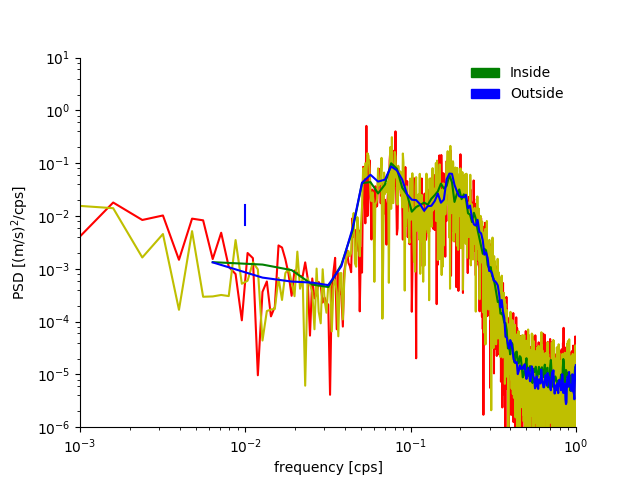

In [61]:
fig, ax = plt.subplots()
fplot=1e-2
plt.loglog(f_in[0:round(N1/2)],S_in[0:round(N1/2)], 'r')
plt.loglog(f_out[0:round(N2/2)],S_out[0:round(N2/2)], 'y')
#plt.loglog(f3_in, S3_in)
plt.loglog(f4_in,S4_in, 'g')
#plt.loglog(f3_out, S3_out)
plt.loglog(f4_out, S4_out, 'b')

plt.ylim([1e-6,1e1])
plt.xlim([1e-3,1])
plt.xlabel('frequency [cps]')
plt.ylabel('PSD [(m/s)$^2$/cps]') #power spectral density 
green_patch = mpatches.Patch(color='green', label='Inside')
blue_patch = mpatches.Patch(color='blue', label='Outside')
plt.legend(loc = 1,bbox_to_anchor=(1, 1.01), handles=[green_patch, blue_patch], frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(np.array([fplot,fplot]), .01*np.array([upper_CI, lower_CI]), 'b-')
plt.savefig('PSD waypoint 11.jpg', dpi=1000)
plt.show()


<IPython.core.display.Javascript object>


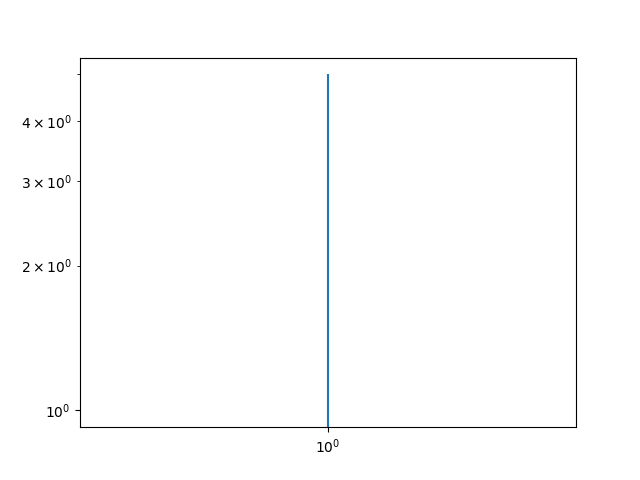

C:\Users\steve\Anaconda3\New folder\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


In [138]:
plt.figure()
plt.errorbar(1,1,4)
plt.yscale('log')
plt.xscale('log')
plt.show()